## Extract FLASH Data in yt
David Schneidinger

9/26/24

Use yt's covering_grid class to extract data from FLASH.

In [3]:
# https://yt-project.org/

import yt
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# plot_path = "./OSIRIS_transfer/MAGOFF/MagShockZ_hdf5_plt_cnt_0004"
plot_path = "~/cellar/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"

In [5]:
# Certain fields are not directly output by FLASH, but can be derived from the fields that are output.
# For example, the number density of electrons and each ion species
# Everything, with the exception of the thermal velocities (which are in osiris units), are in cgs

import sys
sys.path.append("../src")
from load_derived_FLASH_fields import derive_fields
ds = derive_fields(plot_path)

yt : [INFO     ] 2024-09-26 09:45:46,407 Particle file found: MagShockZ_hdf5_chk_0005
yt : [INFO     ] 2024-09-26 09:45:46,771 Parameters: current_time              = 1.8520020414484505e-09
yt : [INFO     ] 2024-09-26 09:45:46,772 Parameters: domain_dimensions         = [288 272 288]
yt : [INFO     ] 2024-09-26 09:45:46,772 Parameters: domain_left_edge          = [-0.6   -0.075 -0.6  ]
yt : [INFO     ] 2024-09-26 09:45:46,772 Parameters: domain_right_edge         = [0.6 1.  0.6]
yt : [INFO     ] 2024-09-26 09:45:46,772 Parameters: cosmological_simulation   = 0


In [2]:
# this is from the yt documentation

level = 2
dims = ds.domain_dimensions * ds.refine_by**level

# We construct an object that describes the data region and structure we want
# In this case, we want all data up to the maximum "level" of refinement
# across the entire simulation volume.  Higher levels than this will not
# contribute to our covering grid.

all_data = ds.covering_grid(
    level,
    left_edge=[-0.6, -0.075, -0.6],
    dims=dims,
    # And any fields to preload (this is optional!)
)
print(type(all_data))   

NameError: name 'ds' is not defined

In [6]:
# All of these numbers come from the INITIAL conditions of FLASH, not the actual values at the given time


ne_cgs = 5e18 # [cm^-3]
e = 4.80320425e-10 # [statC] = [cm^3/2⋅g^1/2⋅s^−1]
m_e = 9.1093837139e-28 # [g]
c = 2.99792458e10 # [cm/s]
kb = 8.617333262e-5 # [eV/K]
proton_mass = 1.6726219e-24 # [g]
B = 150000 # [Gauss]
T_e = 40 # [eV]
Al_charge_state = 6

rqm = 100 # [m_e]
aluminum_molecular_weight = 26.981 # from wikipedia
al_r = 1/aluminum_molecular_weight # reciprocal molecular weight, needs to be same units as sumy
magnesium_molecular_weight = 24.305 # from wikipedia
mg_r = 1/magnesium_molecular_weight # reciprocal molecular weight

omega_pe = np.sqrt(4*np.pi*ne_cgs*e**2/m_e)
rho_0 = aluminum_molecular_weight*proton_mass*ne_cgs/Al_charge_state
alfven_speed = B/np.sqrt(4*np.pi*rho_0) # check this factor of 4pi
print(alfven_speed)
print(B/((omega_pe*m_e*c)/e))
alfven_speed_osiris = (B/np.sqrt(4*np.pi*ne_cgs*rqm*m_e))/c
print(alfven_speed_osiris)
v_th = np.sqrt(T_e/kb/m_e)


6899999.189107501
0.020913952814540445
0.0020913952814540443


In [ ]:
# You need to clean up this code later

def save_slice(normalizations:dict, target_index:int=84):
    '''
    args: normalizations: dict, target_index: int
    normalizations: dict
        key: str, field name
        value: float, normalization factor. Note: function automatically divides by this factor
    target_index: int
        index of the edge of the target
    '''

    # We are looking in the x-y plane at z = 0
    z_middle_index = dims[2] // 2

    # Normalize spatial dimensions to electron inertial length
    x = all_data['flash','x'][:,0,0]*omega_pe/c
    y = all_data['flash','y'][0,target_index:,0]*omega_pe/c

    # Make a directory to hold all of the interpolation objects
    import os
    if not os.path.exists("interp"):
        os.makedirs("interp")

    from scipy.interpolate import RegularGridInterpolator
    import pickle
    

    for field in normalizations.keys():
        field_data = np.array(all_data['flash', field][:, target_index:, z_middle_index])/normalizations[field]
        interp1 = RegularGridInterpolator( (y, x), field_data.T, method='cubic', bounds_error=False, fill_value=0 )
        with open(f"interp/{field}.pkl", "wb") as f:
            pickle.dump(interp1, f)

In [ ]:
# This can take a while and always seems to crash the kernel if you try to do more than 1 or 2. Uncomment as needed

normalizations = {
    # 'aldens':ne_cgs, # check this normalization
    # 'edens':ne_cgs,
    # 'mgdens':ne_cgs,
    # 'magx':(omega_pe*m_e*c)/e,
    # 'magy':(omega_pe*m_e*c)/e,
    # 'magz':(omega_pe*m_e*c)/e,
    # 'Ex':(omega_pe*m_e*c**2)/e,
    # 'Ey':(omega_pe*m_e*c**2)/e, 
    # 'Ez':(omega_pe*m_e*c**2)/e,
}
save_slice(normalizations)

In [15]:
normalizations = {
    # 'velx':alfven_speed/alfven_speed_osiris,
    # 'vely':alfven_speed/alfven_speed_osiris,
    # 'velz':alfven_speed/alfven_speed_osiris,
    # 'vthele':c,
    # 'vthion':c,
}
save_slice(normalizations)

In [1]:
x = all_data['flash','x'][:,0,0]*omega_pe/c
print(f"Bounds of simulation in osiris units: x {round(x.min(),0)},{round(x.max(),0)}")
y = all_data['flash','y'][0,target_index:,0]*omega_pe/c
print(f"Bounds of simulation in osiris units: y {round(y.min(),0)},{round(y.max(),0)}")

NameError: name 'all_data' is not defined

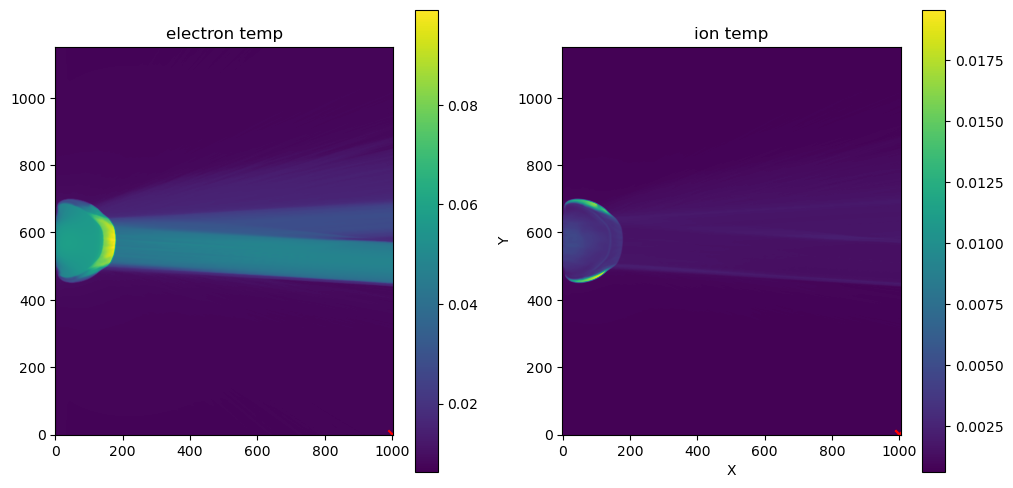

In [19]:
vthele = np.load("FLASH-slices/vthele.npy")
vthion = np.load("FLASH-slices/vthion.npy")
# velz = np.load("FLASH-slices/velz.npy")

point_y=3; point_x=1000  # Replace point_y and point_x with the desired coordinates
# value = all_data['dens'][point_y, point_x]  # Replace point_y and point_x with the desired coordinates
# print("Value at point:", value)

# Add indication on the plot where the point is

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax1.imshow(vthele, origin='lower')
ax1.scatter(point_x, point_y, color='red', marker='x')
ax1.set_title('electron temp')
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(vthion, origin='lower')
ax2.scatter(point_x, point_y, color='red', marker='x')
ax2.set_title('ion temp')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
fig.colorbar(im2, ax=ax2)
plt.scatter(point_x, point_y, color='red', marker='x')

plt.show()
# im.set_clim(0, 200)


In [20]:
x = np.load("FLASH-slices/x.npy")[:,0]
y = np.load("FLASH-slices/y.npy")[0]

# nx = STATE["data"].shape
# x1 = np.linspace( x_bnd[0,0], x_bnd[0,1], nx[1], endpoint=True )
# x2 = np.linspace( x_bnd[1,0], x_bnd[1,1], nx[0], endpoint=True )
# X1, X2 = np.meshgrid( x1, x2, indexing='xy' ) # Matches Fortran array indexing
from scipy.interpolate import RegularGridInterpolator
func = RegularGridInterpolator((x, y), np.load("FLASH-slices/vthele.npy"), bounds_error=False, fill_value=0)
x1 = np.linspace(x.min(), x.max(), 5022)
print(x1)
x2 = np.linspace(y.min(), y.max(), 4206)
xnew, ynew = np.meshgrid(x1, x2, indexing='xy')

points_new = np.array([xnew.flatten(), ynew.flatten()]).T

# synthetic = func(points_new)
# # synthetic = synthetic.reshape((4206, 5022))
# plt.imshow(synthetic, origin='lower')

[-2522.49249572 -2521.48771879 -2520.48294185 ...  2520.48294185
  2521.48771879  2522.49249572]


yt : [INFO     ] 2024-09-25 16:29:35,491 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-09-25 16:29:35,492 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-09-25 16:29:35,500 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-09-25 16:29:35,504 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-09-25 16:29:35,514 Making a fixed resolution buffer of (('flash', 'edens')) 800 by 800



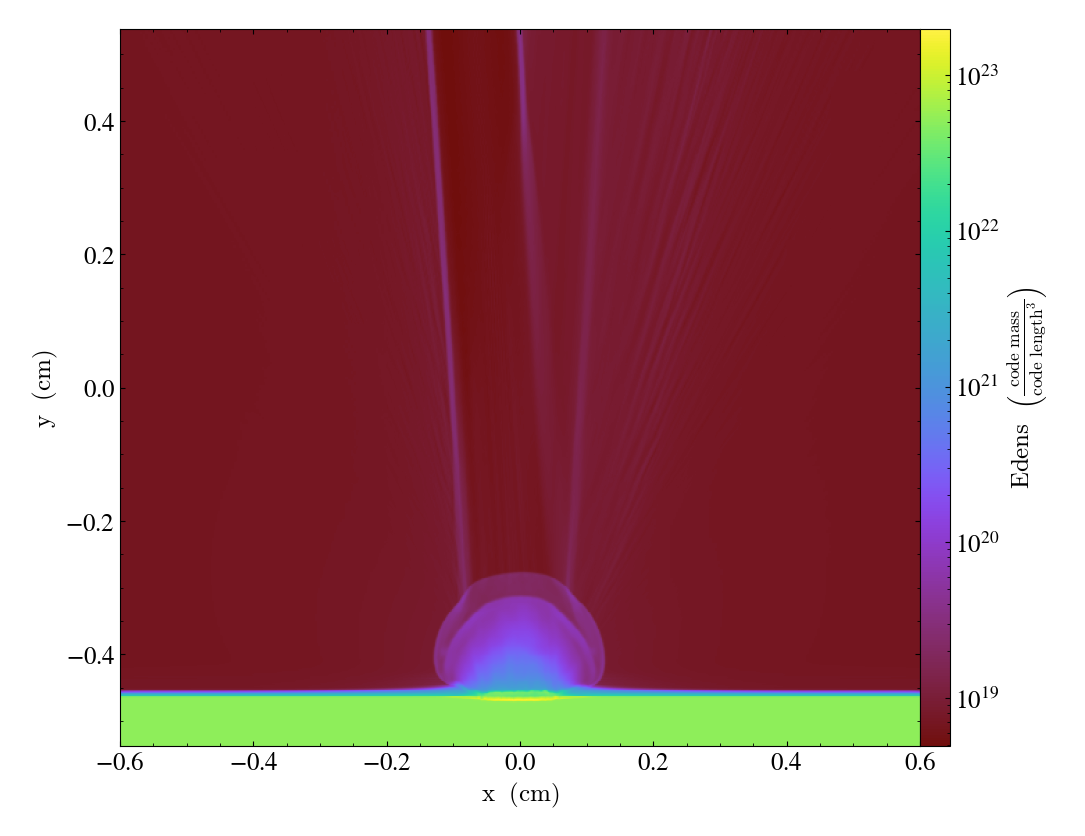

In [7]:
yt.SlicePlot(ds, 'z', 'edens')